In [179]:
from collections import defaultdict
from dataclasses import dataclass
import os
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

@dataclass
class EEGData:
    eegs: dict[str, pl.DataFrame]
    spects: dict[str, pl.DataFrame]

    def get_eeg(id):
        return self.eeg[id]

    def get_spect(id):
        return self.spects[id]

def build_eegfiles(eegs_ids, spectra_ids, eegs_path, spectra_path):
    eegs_dict = {}
    for _id in tqdm(eegs_ids):
        if not isinstance(_id, int):
            continue
        eegs_dict[_id] = pl.read_parquet(os.path.join(eegs_path, str(_id)+".parquet"))

    spectra_dict = {}
    for _id in tqdm(spectra_ids):
        if not isinstance(_id, int):
            continue
        spectra_dict[_id] = pl.read_parquet(os.path.join(spectra_path, str(_id)+".parquet"))
    
    return EEGData(eegs_dict, spectra_dict)

In [214]:
train_df = pl.read_csv("data/train.csv")
train_df = train_df.with_columns(pl.int_range(train_df.shape[0]).alias('sample_id'))
train_df.limit(2)

eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,sample_id
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0,1


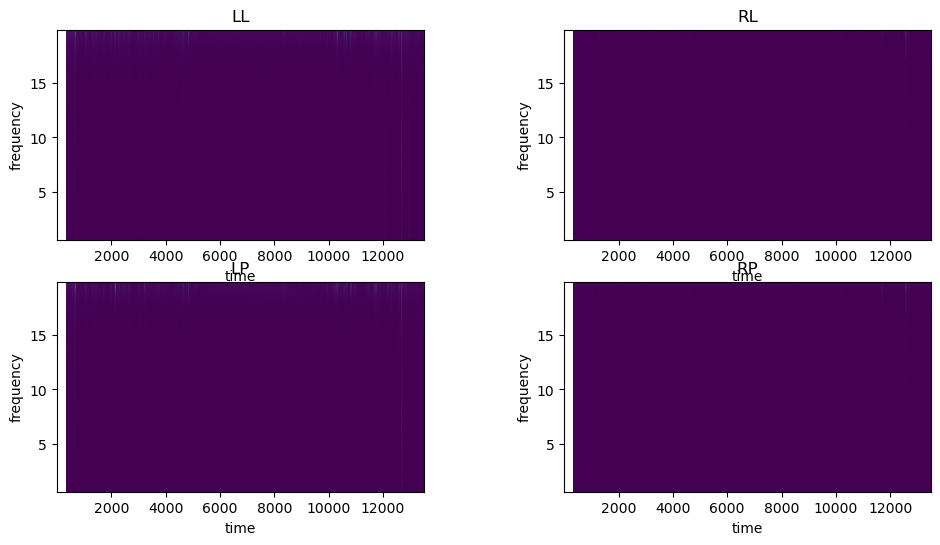

In [29]:
pq_spect_t = pl.read_parquet(os.path.join("data/train_spectrograms", "1863712617.parquet"))
t_spect =pq_spect_t['time']
pq_spect = pq_spect_t.drop('time')
spect_subsets = defaultdict(list)
for cn in pq_spect.columns:
    spect_subsets[cn[:2]].append(cn)

freqs = [float(x.split('_')[1]) for x in spect_subsets['LL']]

fig, ax = plt.subplots(2, 2, figsize=[12,6])
for ix, part in enumerate(spect_subsets):
    ix_x = ix//2
    ix_y = ix%2
    ax[ix_x, ix_y].imshow(np.sqrt(pq_spect[spect_subsets[part]].to_numpy().T), extent=[min(t_spect), max(t_spect), min(freqs), max(freqs)], aspect=400)
    ax[ix_x, ix_y].set_xlabel('time')
    ax[ix_x, ix_y].set_ylabel('frequency')
    ax[ix_x, ix_y].set_title(part)

In [106]:
df_sample = train_df['spectrogram_id'].unique().limit(100)
df_train_sample = train_df.join(pl.DataFrame(df_sample), on="spectrogram_id")

In [107]:
eeg_files = build_eegfiles(
    df_train_sample['eeg_id'].unique(),
    df_train_sample['spectrogram_id'].unique(),
    "data/train_eegs",
    "data/train_spectrograms",
)

In [215]:
rowix = 0

# 200 samples / second
row = df_train_sample[rowix]
eeg_files.eegs[df_train_sample[rowix, 'eeg_id']].limit(2)

Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
-80.519997,-70.540001,-80.110001,-108.75,-120.330002,-88.620003,-101.75,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.92
-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.82,-104.260002,-99.730003,-99.07,-92.290001,-96.019997,-84.5,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.5,-102.059998,29.219999


In [216]:
# .5 samples / second
eeg_files.spects[df_train_sample[rowix, 'spectrogram_id']].shape

(320, 401)

shape: (2, 21)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────┐
│ Fp1        ┆ F3         ┆ C3         ┆ P3        ┆ … ┆ T6        ┆ O2        ┆ EKG       ┆ t     │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---   │
│ f32        ┆ f32        ┆ f32        ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f64   │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ -80.519997 ┆ -70.540001 ┆ -80.110001 ┆ -108.75   ┆ … ┆ -121.7300 ┆ -106.4499 ┆ 7.92      ┆ 0.0   │
│            ┆            ┆            ┆           ┆   ┆ 03        ┆ 97        ┆           ┆       │
│ -80.449997 ┆ -70.330002 ┆ -81.760002 ┆ -107.6699 ┆ … ┆ -115.5    ┆ -102.0599 ┆ 29.219999 ┆ 0.005 │
│            ┆            ┆            ┆ 98        ┆   ┆           ┆ 98        ┆           ┆       │
└────────────┴────────────┴────────────┴───────────┴───┴───────────┴────────

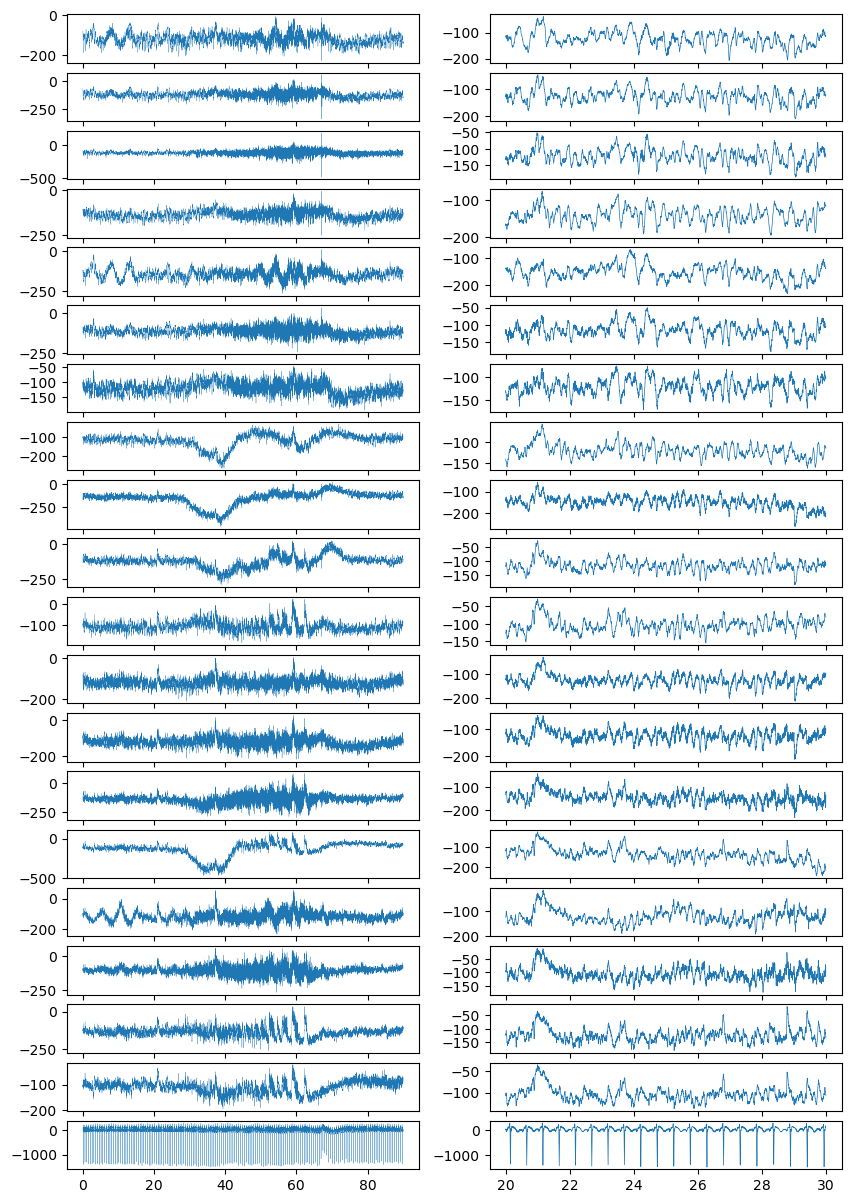

In [217]:
# Show the EEG
eeg_offset = df_train_sample[rowix, "eeg_label_offset_seconds"] * 200

pq_eeg  = eeg_files.eegs[df_train_sample[rowix, 'eeg_id']]
row_eeg = pq_eeg.with_columns(pl.Series(np.linspace(0,pq_eeg.shape[0]/200, num=pq_eeg.shape[0], endpoint=False)).alias('t'))
filt_row_eeg = row_eeg.filter((pl.col("t") >= 20) & (pl.col("t") < 30))

print(row_eeg.limit(2))
fig, ax = plt.subplots(pq_eeg.shape[1], 2, figsize=(10,15))
for ix, col in enumerate(pq_eeg.columns):
    ax[ix,0].plot(row_eeg['t'], row_eeg[col], linewidth=.2)
    ax[ix,1].plot(filt_row_eeg['t'], filt_row_eeg[col], linewidth=.5)


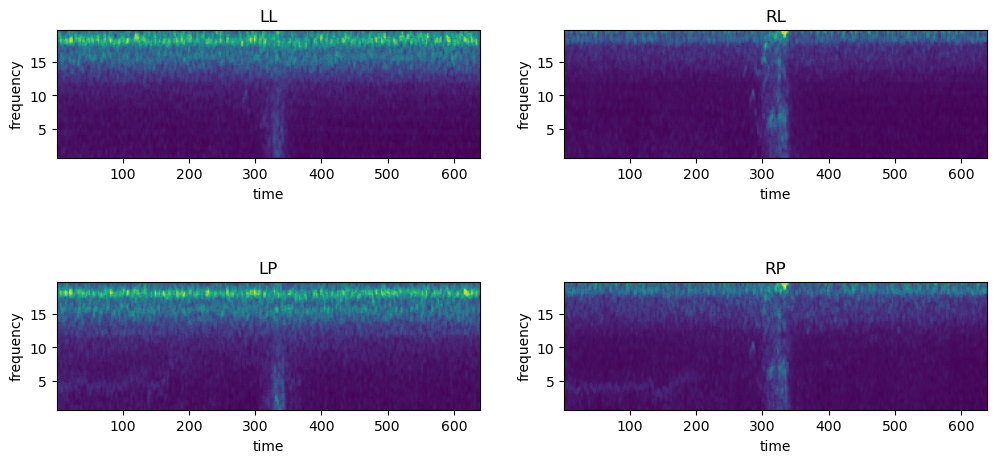

In [221]:
# Show the spectrogram
spectrogram_offset = df_train_sample[rowix, "spectrogram_label_offset_seconds"] * .5
spectrogram_data_offset = spectrogram_offset + 12

pq_spect_t = eeg_files.spects[df_train_sample[rowix, 'spectrogram_id']]
t_spect =pq_spect_t['time']
pq_spect = pq_spect_t.drop('time')
spect_subsets = defaultdict(list)
for cn in pq_spect.columns:
    spect_subsets[cn[:2]].append(cn)

freqs = [float(x.split('_')[1]) for x in spect_subsets['LL']]

fig, ax = plt.subplots(2, 2, figsize=[12,6])
for ix, part in enumerate(spect_subsets):
    ix_x = ix//2
    ix_y = ix%2
    ax[ix_x, ix_y].imshow(np.sqrt(pq_spect[spect_subsets[part]].to_numpy().T), extent=[min(t_spect), max(t_spect), min(freqs), max(freqs)], aspect=10)
    ax[ix_x, ix_y].set_xlabel('time')
    ax[ix_x, ix_y].set_ylabel('frequency')
    ax[ix_x, ix_y].set_title(part)


In [227]:
pq_spect_t.filter((pl.col("time") < 30) & (pl.col("time") > 20)).mean().drop("time")

LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,LL_2.54,LL_2.73,LL_2.93,LL_3.13,LL_3.32,LL_3.52,LL_3.71,LL_3.91,LL_4.1,LL_4.3,LL_4.49,LL_4.69,LL_4.88,LL_5.08,LL_5.27,LL_5.47,LL_5.66,LL_5.86,LL_6.05,LL_6.25,LL_6.45,LL_6.64,LL_6.84,LL_7.03,LL_7.23,LL_7.42,LL_7.62,…,RP_12.89,RP_13.09,RP_13.28,RP_13.48,RP_13.67,RP_13.87,RP_14.06,RP_14.26,RP_14.45,RP_14.65,RP_14.84,RP_15.04,RP_15.23,RP_15.43,RP_15.63,RP_15.82,RP_16.02,RP_16.21,RP_16.41,RP_16.6,RP_16.8,RP_16.99,RP_17.19,RP_17.38,RP_17.58,RP_17.77,RP_17.97,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
5.266,6.298,8.944,9.366,11.57,13.884,17.358,21.312,20.552,21.716,16.177999,11.468,7.18,4.708,3.562,3.79,4.244,4.798,5.364,4.566,4.562,4.34,4.09,5.192,6.078,5.288,4.844,3.57,2.682,2.202,2.056,2.458,2.272,2.488,2.354,1.582,1.214,…,0.166,0.16,0.136,0.132,0.134,0.136,0.176,0.202,0.206,0.186,0.168,0.236,0.236,0.318,0.438,0.44,0.466,0.52,0.534,0.704,0.854,0.752,0.7,0.606,0.396,0.45,0.36,0.302,0.33,0.294,0.306,0.302,0.29,0.294,0.276,0.336,0.318


In [284]:
# End of EDA

In [ ]:
# Code snippets
## # Make "pos/neg" features
## floor = 1.0
## cns_ekg = df_train_X.columns[:20]
## df_train_X = df_train_X.with_columns(
##     *[
##         (pl.col(cn).clip(floor).alias(cn+"_pos").log() - pl.lit(np.log(floor))).clip(0)
##         for cn in cns_ekg
##     ],
##     *[
##         (pl.col(cn).clip(None, -floor).abs().alias(cn+"_neg").log() - pl.lit(np.log(floor))).clip(0)
##         for cn in cns_ekg
##     ],
## )


In [ ]:
# Begin train & eval modules

In [5]:
def build_features(rowix, df, eeg_files, print_missing=False):
    # EEG features
    t_offset = df[rowix, "eeg_label_offset_seconds"]
    t0 = t_offset+20
    tf = t_offset+30
    pq_eeg  = eeg_files.eegs[df[rowix, 'eeg_id']]
    row_eeg = pq_eeg.with_columns(pl.Series(np.linspace(0,pq_eeg.shape[0]/200, num=pq_eeg.shape[0], endpoint=False)).alias('t'))
    filt_row_eeg = row_eeg.filter((pl.col("t") >= t0) & (pl.col("t") < tf))
    eeg_features = filt_row_eeg.drop("t").mean()
    # eeg_features = pl.DataFrame({cn+"_avg":filt_row_eeg[cn].mean() for cn in pq_eeg.columns})
    
    # Spectrogram features
    t_offset = df[rowix, "spectrogram_label_offset_seconds"]
    t0 = t_offset+20
    tf = t_offset+30
    pq_spect_t = eeg_files.spects[df[rowix, 'spectrogram_id']]
    pq_spect_filt = pq_spect_t.filter((pl.col("time") > t0) & (pl.col("time") < tf))
    if print_missing and (pq_spect_filt.null_count().to_numpy() > 0).any():
        print(f"WARNING: Null values found in {df[rowix, 'spectrogram_id']}")
    spect_features = pq_spect_filt.mean().drop("time")
    return(eeg_features, spect_features)


In [43]:
from tqdm import tqdm

def featurize_Xy(df_tabular, method = "melt", print_missing=False):
    N=df_tabular.shape[0]
    df_tabular = df_tabular.with_columns(rowix=pl.Series(range(N)))

    print("Loading EEG files...")
    eeg_files = build_eegfiles(
        df_tabular['eeg_id'].unique(),
        df_tabular['spectrogram_id'].unique(),
        "data/train_eegs",
        "data/train_spectrograms",
    )
    print("Building Features...")
    df_feature = pl.concat([pl.concat(build_features(ix, df_tabular, eeg_files, print_missing), how="horizontal") for ix in tqdm(range(N))])
    cns_feature = df_feature.columns

    pred_classes = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
    class_vote = {x:x.split("_")[0] for x in pred_classes}
    df_input = pl.concat([df_tabular, df_feature], how="horizontal")
    if method == "melt":
        print("Melting DataFrame...")
        df_labels = pl.concat([
             pl.DataFrame({
                 "rowix":row, 
                 "vote":class_vote[col],
                 "wt":df_tabular[row,col],
                 "consensus":df_tabular[row,"expert_consensus"]
             }) 
             for row in tqdm(range(N))
             for col in pred_classes
             if df_tabular[row,col] > 0
        ])
        df_input = df_input.join(df_labels, on="rowix")
        cns_label = "vote"
    elif method == "dirichlet":
        print("Returning dirichlet distribution of output classes")
        df_input = df_input.with_columns(
            *[
                pl.col(_class) / pl.sum_horizontal(*pred_classes) for _class in pred_classes
            ]
        )
        cns_label=pred_classes
    else:
        raise ValueError("Method not recognized")
    
    df_input = df_input.drop_nulls()
    df_input_X = df_input[cns_feature]
    df_input_y = df_input[cns_label]

    if method=="melt":
        extra = {
            "wt":df_input["wt"],
            "consensus":df_input["consensus"], 
            "vote_encode":{x:i for i, x in enumerate(pred_classes)}
            
        }
    else:
        extra={}

    return df_input_X, df_input_y, extra


def train_model(df_tabular):
    df_input_X, df_input_y, df_weight = featurize_Xy(df_tabular)
    model = RandomForestClassifier()
    print("Fitting model...")
    model.fit(df_input_X, df_input_y, df_weight)
    return model

def predict_model(df_tabular, model):
    df_input_X, df_input_y, _ = featurize_Xy(df_tabular, method="melt")
    return df_input_X, df_input_y, model.predict(df_tabular)

In [29]:
N_fold = 10

df_core = pl.read_csv("data/train.csv")
fold_assignment = df_core[['spectrogram_id']].with_columns(((pl.col("spectrogram_id") // 10) % (N_fold+1)).alias("fold"))
print(sorted([(fold, count) for fold,count in Counter(fold_assignment["fold"]).items()]))
df_core_fold = df_core.join(fold_assignment, on="spectrogram_id")

df_validate = df_core_fold.filter(pl.col("fold") == N_fold)
df_validate.sample(2)

[(0, 9544), (1, 7973), (2, 10195), (3, 8499), (4, 9134), (5, 9045), (6, 11089), (7, 11846), (8, 10361), (9, 9855), (10, 9259)]


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,fold
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64
3591791883,19,122.0,1863712617,541,10290.0,3709737966,35225,"""LPD""",0,3,0,0,0,0,10
1424847642,25,200.0,1863712617,130,2474.0,2208435314,35225,"""LPD""",0,4,0,0,0,1,10


In [44]:
fold = 10
df_train = df_core_fold.filter((pl.col("fold") != fold) & (pl.col("fold") < N_fold)).sample(1E4)
df_fold  = df_core_fold.filter((pl.col("fold") == fold))

df_train_X, df_train_y, train_extra = featurize_Xy(df_train, "melt")
df_train_X_dir, df_train_y_dir, _ = featurize_Xy(df_train, "dirichlet")
df_test_X, df_test_y, _ = featurize_Xy(df_fold.sample(1E4), "dirichlet")

Loading EEG files...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:02<00:00, 383.38it/s]


Building Features...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 530.30it/s]


Melting DataFrame...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 15464.92it/s]


Loading EEG files...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:00<00:00, 410.70it/s]


Building Features...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 632.05it/s]


Returning dirichlet distribution of output classes


In [154]:
df_train_X_dir, df_train_y_dir, _ = featurize_Xy(df_train.sample(1E4), "dirichlet")

Loading EEG files...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:03<00:00, 357.58it/s]


Building Features...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 556.06it/s]


Returning dirichlet distribution of output classes


In [100]:
import sklearn.feature_selection
pred_classes = ["seizure", "lpd", "gpd", "lrda", "grda", "other"]
df_train_y_int = df_train_y.replace({cn:int(ix) for ix,cn in enumerate(pred_classes)}).cast(pl.Int64)
consensus_rows=(train_extra["consensus"].str.to_lowercase()==df_train_y).to_numpy()

print(df_train_y_int.to_numpy())

print("No consensus filter:")
mi = sklearn.feature_selection.mutual_info_regression(
    df_train_X,
    df_train_y_int,
)
for x in sorted(zip(mi,df_train_X.columns), reverse=True)[:10]:
    print(x)
for x in sorted(zip(mi,df_train_X.columns), reverse=True)[-10:]:
    print(x)

## print("\nConsensus only, cube-root:")
## mi = sklearn.feature_selection.mutual_info_regression(
##     np.cbrt(df_train_X.to_numpy()[consensus_rows,:]),
##     df_train_y_int.to_numpy()[consensus_rows],
## )
## for x in sorted(zip(mi,df_train_X.columns), reverse=True)[:10]:
##     print(x)
## for x in sorted(zip(mi,df_train_X.columns), reverse=True)[-10:]:
##     print(x)

print("\nConsensus only:")
mi = sklearn.feature_selection.mutual_info_regression(
    df_train_X.to_numpy()[consensus_rows,:],
    df_train_y_int.to_numpy()[consensus_rows],
)
for x in sorted(zip(mi,df_train_X.columns), reverse=True)[:10]:
    print(x)
for x in sorted(zip(mi,df_train_X.columns), reverse=True)[-10:]:
    print(x)

[1 3 5 ... 2 5 0]
No consensus filter:
(0.20233411433924253, 'EKG')
(0.19495702757720768, 'LP_9.96')
(0.18972611251425953, 'RL_10.55')
(0.1892771190978575, 'LL_5.66')
(0.1891608055239118, 'RL_5.08')
(0.18846541469069855, 'RL_8.79')
(0.18817806814823257, 'RL_4.1')
(0.18614489446141125, 'RL_9.77')
(0.1850779513922287, 'RL_9.57')
(0.18484285884132934, 'RL_9.96')
(0.07944848956204353, 'C3')
(0.07919775295954956, 'T3')
(0.0783993189947001, 'LP_1.17')
(0.07749679539979581, 'LL_0.59')
(0.0774320975400844, 'RP_1.17')
(0.07738861120244245, 'T5')
(0.07598786458848217, 'RL_0.59')
(0.0735289592944035, 'P3')
(0.07186793119446655, 'F4')
(0.05186562668938066, 'Pz')

Consensus only:
(0.532263523603528, 'EKG')
(0.4892339367828882, 'LP_3.91')
(0.48701387433431087, 'LL_5.47')
(0.4860478049569803, 'LL_5.66')
(0.47936917192467554, 'LP_3.71')
(0.4719273635400043, 'LL_5.08')
(0.4684146879875346, 'LP_5.86')
(0.4683516032633861, 'C4')
(0.4675533635144129, 'RL_4.69')
(0.46662258448601346, 'LP_5.47')
(0.24899215

In [183]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
df_train_X.sample(2)

Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,LL_2.54,LL_2.73,LL_2.93,LL_3.13,LL_3.32,LL_3.52,LL_3.71,…,RP_12.89,RP_13.09,RP_13.28,RP_13.48,RP_13.67,RP_13.87,RP_14.06,RP_14.26,RP_14.45,RP_14.65,RP_14.84,RP_15.04,RP_15.23,RP_15.43,RP_15.63,RP_15.82,RP_16.02,RP_16.21,RP_16.41,RP_16.6,RP_16.8,RP_16.99,RP_17.19,RP_17.38,RP_17.58,RP_17.77,RP_17.97,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
-3.408195,-28.638704,-10.69362,13.556295,-8.334065,-30.69663,-11.911945,-9.462775,-3.114085,16.93367,0.97972,-26.430824,-30.868805,-64.562531,20.85162,-12.340675,21.86581,5.62351,5.44265,-46.705765,38.911999,65.036003,93.959999,112.795998,159.223999,228.862,247.033997,237.447998,205.600006,115.802002,61.492001,33.102001,23.52,24.798,25.546,26.59,21.608,…,0.216,0.218,0.246,0.244,0.232,0.24,0.258,0.242,0.256,0.196,0.202,0.212,0.206,0.18,0.136,0.122,0.114,0.116,0.118,0.124,0.142,0.14,0.166,0.14,0.134,0.12,0.088,0.078,0.086,0.102,0.098,0.128,0.128,0.092,0.116,0.09,0.09
-6.041455,-14.559615,-7.655555,-20.250971,1.49178,-24.181549,-27.48918,-54.076595,-13.420195,-34.166061,-14.481475,16.281361,-21.883724,-29.75091,-17.843254,-32.220886,-3.325955,-28.783951,-7.656625,-32.794735,40.816002,47.043999,61.012001,55.372002,51.119999,48.835999,33.375999,23.096001,17.389999,12.572,8.522,8.889999,9.06,9.726,9.424,6.108,6.004,…,0.184,0.176,0.178,0.208,0.232,0.256,0.256,0.246,0.214,0.208,0.204,0.192,0.182,0.196,0.184,0.172,0.196,0.144,0.174,0.17,0.148,0.15,0.152,0.162,0.162,0.166,0.182,0.166,0.164,0.152,0.128,0.12,0.116,0.118,0.13,0.14,0.142


<Axes: >

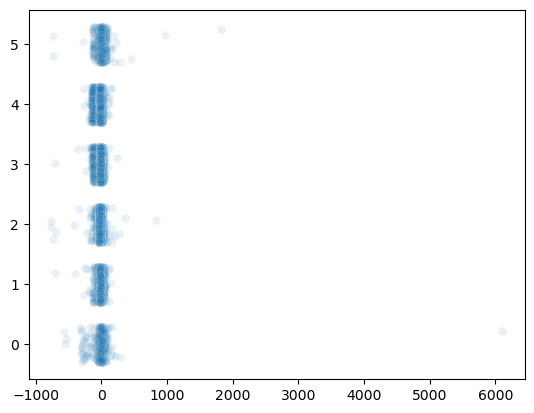

In [184]:
import seaborn as sns
df_train_y_int = df_train_y.replace({cn:ix for ix,cn in enumerate(pred_classes)}).cast(pl.Int64)
consensus_rows=(train_extra["consensus"].str.to_lowercase()==df_train_y).to_numpy()
sns.scatterplot(
    x=df_train_X.to_numpy()[consensus_rows,1],
    y=df_train_y_int.to_numpy()[consensus_rows]+np.random.uniform(-.3,.3, np.sum(consensus_rows)),
    alpha=0.1,
    # plot_kws={'alpha': 0.1}
)
# sns.scatterplot(
#     x=df_train_X_ft.to_numpy()[consensus_rows,1],
#     y=df_train_y_int.to_numpy()[consensus_rows]+np.random.uniform(-.3,.3, np.sum(consensus_rows)),
#     alpha=0.1,
#     # plot_kws={'alpha': 0.1}
# )

In [226]:
def kl(model, df_X, df_y, by_sample=False,baseline=True):
    eps = 1E-15
    p_min = eps
    p_max = 1-eps
    q = np.clip(model.predict_proba(df_X), p_min, p_max)
    p = np.clip(df_y[[cl+"_vote" for cl in model.classes_]].to_numpy(), p_min, p_max)
    kl_by_sample=np.sum(p*(np.log(p) - np.log(q)), axis=1)
    if baseline:
        q = np.ones(p.shape) * 1./6
        kl_baseline = np.sum(p*(np.log(p) - np.log(q))).sum() / p.shape[0]
        print(f"RANDOM BASELINE:", kl_baseline)
    if by_sample:
        return kl_by_sample
    return kl_by_sample.sum() / p.shape[0]



In [229]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(30)), ('reg', LogisticRegression(max_iter=1000))])

model = pipe.fit(
    df_train_X,
    df_train_y,
    reg__sample_weight=train_extra["wt"],
)
# print(kl(pipe, df_train_X_dir, df_train_y_dir))
print(kl(pipe, df_test_X, df_test_y))

RANDOM BASELINE: 1.277565211798
1.2403508073350893
RANDOM BASELINE: 1.3853745162408617
1.455403925814748


In [244]:
model = RandomForestClassifier()
print("Fitting model...")
model = model.fit(
    df_train_X,
    df_train_y,
    train_extra["wt"],
)
print(kl(model, df_train_X_dir, df_train_y_dir))
print(kl(model, df_test_X, df_test_y))

Fitting model...
RANDOM BASELINE: 1.277565211798
0.07379193908058011
RANDOM BASELINE: 1.3853745162408617
0.9804655944776143


In [246]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('reg', RandomForestClassifier(max_depth=20))])
print("Fitting model...")
model = pipe.fit(
    df_train_X,
    df_train_y,
    reg__sample_weight=train_extra["wt"],
)
print(kl(model, df_train_X_dir, df_train_y_dir))
print(kl(model, df_test_X, df_test_y))

Fitting model...
RANDOM BASELINE: 1.277565211798
0.1438711579117186
RANDOM BASELINE: 1.3853745162408617
0.9701089190308018


In [247]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('reg', RandomForestClassifier(min_samples_split=10))])
print("Fitting model...")
model = pipe.fit(
    df_train_X,
    df_train_y,
    reg__sample_weight=train_extra["wt"],
)
print(kl(model, df_train_X_dir, df_train_y_dir))
print(kl(model, df_test_X, df_test_y))

Fitting model...
RANDOM BASELINE: 1.277565211798
0.1365502979995247
RANDOM BASELINE: 1.3853745162408617
0.9546800300032388


In [245]:
model = RandomForestClassifier()
print("Fitting model...")
model = model.fit(
    df_train_X.to_numpy()[consensus_rows,:],
    df_train_y.to_numpy()[consensus_rows],
    train_extra["wt"].to_numpy()[consensus_rows]
)
print(kl(model, df_train_X_dir, df_train_y_dir))
print(kl(model, df_test_X, df_test_y))

Fitting model...
RANDOM BASELINE: 1.277565211798
3.7640690977617464
RANDOM BASELINE: 1.3853745162408617
1.1294940141883951


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
